----------------

```{admonition} Learning Objectives
- Reproject remotely sensed data (change CRS) using rioxarray
- Apply on-the-fly coordinate system transformations
- Compare different resampling algorithms and their effects
- Combine CRS transformations with resolution changes
```
----------------


# Remote Sensing Coordinate Reference Systems with Rioxarray

Rioxarray provides powerful coordinate reference system (CRS) transformation capabilities through its `rio.reproject()` method. This functionality is built on rasterio's CRS handling and virtual warping capabilities, allowing for efficient on-the-fly reprojections. For CRS references, see [Spatial Reference](https://spatialreference.org/) and [epsg.io](http://epsg.io/).

## Viewing CRS and Spatial Properties
Rioxarray's `rio` accessor provides direct access to all spatial reference information including coordinate reference system, spatial transform, resolution, and bounds.

In [1]:
import rioxarray as rxr

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

src = rxr.open_rasterio(image_path)
print("Transform:", src.rio.transform())
print("CRS:", src.rio.crs)
print("Resolution:", src.rio.resolution())
print("Shape:", src.shape)
print("Cell size X:", abs(src.rio.resolution()[0]))
print("Cell size Y:", abs(src.rio.resolution()[1]))

Transform: | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00|
CRS: EPSG:32621
Resolution: (30.0, -30.0)
Shape: (3, 1860, 2041)
Cell size X: 30.0
Cell size Y: 30.0


## CRS Transformation (Reprojection) with Rioxarray

To transform the coordinate reference system, use rioxarray's `rio.reproject()` method. This method accepts various CRS formats including PROJ4 strings, EPSG codes, or authority:code formats like `EPSG:4326` or `ESRI:53018`. The transformation uses rasterio's virtual warping for memory-efficient processing.

Transform: | 36.06, 0.00, 5962242.52|
| 0.00,-36.06,-5200905.12|
| 0.00, 0.00, 1.00|
CRS: ESRI:102008
Resolution: (36.0575219213484, -36.0575219213484)


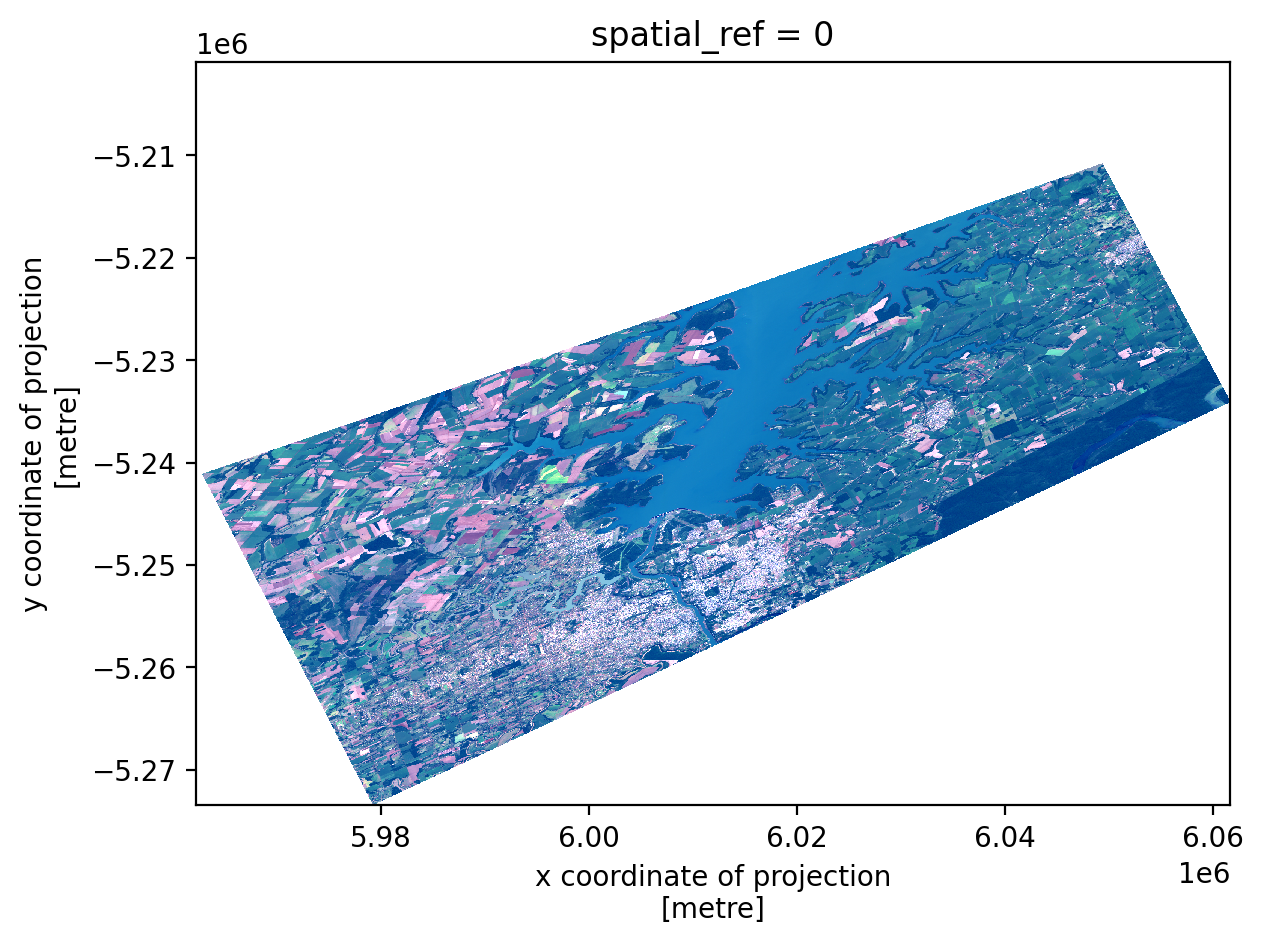

In [2]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
from rasterio.enums import Resampling

fig, ax = plt.subplots(dpi=200)
proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
src = rxr.open_rasterio(image_path).rio.write_nodata(0)

# Transform CRS and replace 0 with nan
src_transformed = src.rio.reproject(proj4, resampling=Resampling.nearest)
src_masked = src_transformed.where(src_transformed != 0, np.nan)

print("Transform:", src_masked.rio.transform())
print("CRS:", src_masked.rio.crs)
print("Resolution:", src_masked.rio.resolution())

# Plot bands 3,2,1 (indices 2,1,0) - adjust if only 3 bands available
if len(src_masked.band) >= 3:
    src_masked.isel(band=[2, 1, 0]).plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Alternative CRS Formats

Rioxarray supports various CRS specification formats through rasterio. Here we demonstrate using an EPSG code for UTM Zone 18N projection.

In [3]:
import rioxarray as rxr
from rasterio.enums import Resampling

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
src = rxr.open_rasterio(image_path)

# Transform to UTM Zone 18N (EPSG:32618)
src_utm = src.rio.reproject("EPSG:32618", resampling=Resampling.nearest)

print("Transform:", src_utm.rio.transform())
print("CRS:", src_utm.rio.crs)
print("Resolution:", src_utm.rio.resolution())

Transform: | 31.61, 0.00, 2551337.44|
| 0.00,-31.61,-2933269.13|
| 0.00, 0.00, 1.00|
CRS: EPSG:32618
Resolution: (31.605075990530455, -31.605075990530455)


## Resampling Algorithms for Resolution Changes

Resampling refers to changing the spatial resolution (pixel size) of raster data. Rioxarray supports multiple resampling algorithms through rasterio's Resampling enum:

- `nearest`: Uses the value of the closest pixel - best for categorical data
- `bilinear`: Uses weighted average of 4 nearest pixels - good for continuous data
- `cubic`: Uses weighted average of 16 nearest pixels - smoothest results for continuous data

The resampling algorithm significantly affects the output quality and should be chosen based on your data type and analysis needs.

In [4]:
import rioxarray as rxr
from rasterio.enums import Resampling

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
src = rxr.open_rasterio(image_path)

# Transform to EPSG:31972 with cubic resampling
src_transformed = src.rio.reproject("EPSG:31972", resampling=Resampling.cubic)

print("Transform:", src_transformed.rio.transform())
print("CRS:", src_transformed.rio.crs)
print("Resolution:", src_transformed.rio.resolution())

Transform: | 31.61, 0.00, 2551337.44|
| 0.00,-31.61,-2933269.13|
| 0.00, 0.00, 1.00|
CRS: EPSG:31972
Resolution: (31.605075990299333, -31.605075990299333)


## Combining CRS Transformation with Resolution Change

You can simultaneously change both the coordinate system and spatial resolution in a single reproject operation. This example resamples the data to 10m x 10m pixel resolution while transforming to a different projection.

In [5]:
import rioxarray as rxr
from rasterio.enums import Resampling

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
src = rxr.open_rasterio(image_path)

# Transform to EPSG:31972 with 10m resolution and cubic resampling
src_transformed = src.rio.reproject(
    "EPSG:31972", 
    resolution=(10, 10), 
    resampling=Resampling.cubic
)

print("Transform:", src_transformed.rio.transform())
print("CRS:", src_transformed.rio.crs)
print("Resolution:", src_transformed.rio.resolution())

Transform: | 10.00, 0.00, 2551337.44|
| 0.00,-10.00,-2933269.13|
| 0.00, 0.00, 1.00|
CRS: EPSG:31972
Resolution: (10.0, -10.0)


## Direct Transformation Without Context

Rioxarray's `rio.reproject()` method can be used directly on any DataArray for immediate transformation. This approach gives you fine-grained control over transformation parameters including custom resolution and resampling methods.

In [6]:
import rioxarray as rxr
from rasterio.enums import Resampling

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

src = rxr.open_rasterio(image_path)

# Direct transformation with custom resolution
src_tr = src.rio.reproject(
    proj4, 
    resolution=(10, 10), 
    resampling=Resampling.bilinear
)

print("Transform:", src_tr.rio.transform())
print("CRS:", src_tr.rio.crs)
print("Resolution:", src_tr.rio.resolution())

Transform: | 10.00, 0.00, 5962242.52|
| 0.00,-10.00,-5200905.12|
| 0.00, 0.00, 1.00|
CRS: ESRI:102008
Resolution: (10.0, -10.0)
